# GPT3 Classifier

## Setup

### Mount Google Drive

Mount Google Drive. Inside `DRIVE_PATH` there should be the necessary data as well as the api key in a file.

In [46]:
OPENAI_API_KEY_FILE = "MyDrive/colab/XAI/OPENAI_API_KEY_3.txt"
DRIVE_MOUNT_PATH = '/drive/'
DATA_FOLDER = "MyDrive/public/TUM XAI/classifiers/data/"
TRAIN_VAL_FILE = "classifier_input_restricted_train.csv"

In [28]:
from google.colab import drive
drive.mount(DRIVE_MOUNT_PATH)

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


### Libraries

In [29]:
!pip install --upgrade --no-cache-dir transformers openai==0.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import os
import random
import sqlite3
import requests
import time
import copy
from shutil import copytree, copyfile
from pathlib import Path
from typing import Optional
from datetime import datetime
from io import BytesIO

import numpy as np
import pandas as pd
import tensorflow as tf
import openai
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2TokenizerFast

### Seed

In [31]:
SEED: int = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

### Api key

In [47]:
if os.path.exists('OPENAI_API_KEY.txt'): os.remove('OPENAI_API_KEY.txt')
copyfile(DRIVE_MOUNT_PATH + OPENAI_API_KEY_FILE, 'OPENAI_API_KEY.txt')
openai.api_key_path = 'OPENAI_API_KEY.txt'
openai_api_key = None
with open('OPENAI_API_KEY.txt', 'r') as f:
  openai_api_key = f.read()

## Load data

Copy data from Drive to disk:

In [32]:
N_TRAIN_VAL = 3000
VAL_SPLIT = 0.2

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

if not os.path.exists('data'):
  os.mkdir('data')

copyfile(DRIVE_MOUNT_PATH + DATA_FOLDER + TRAIN_VAL_FILE, 'data/train_val.csv')

df_train_val: pd.DataFrame = pd.read_csv('data/train_val.csv')
df_train_val = shuffle(df_train_val).reset_index(inplace=False, drop=True).head(N_TRAIN_VAL)
df_train, df_val = train_test_split(df_train_val, test_size=VAL_SPLIT, random_state=SEED, shuffle=True)

print("df_train", df_train.shape)
print(df_train["src"].value_counts())
print("\ndf_val", df_val.shape)
print(df_val["src"].value_counts())

df_train (2400, 9)
real         1157
gpt2          330
scigen        318
galactica     302
chatgpt       293
Name: src, dtype: int64

df_val (600, 9)
real         324
gpt2          76
galactica     70
chatgpt       69
scigen        61
Name: src, dtype: int64


## Prepare prompts and completions

In [34]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
  # Add completion
  df["completion"] = " " + df["label"].astype(str)

  # Create prompt
  df["prompt"] = "Abstract:\n" + df["abstract"] \
    + "\n\nIntroduction:\n" + df["introduction"] \
    + "\n\nConclusion:\n" + df["conclusion"] \
    + "\n\n###\n\n"

  return df[["prompt", "completion"]]


df_train_prepared = prepare_data(df_train)
df_val_prepared = prepare_data(df_val)
assert df_train_prepared["completion"].value_counts()[" 0"] == df_train["src"].value_counts()["real"]
assert df_val_prepared["completion"].value_counts()[" 0"] == df_val["src"].value_counts()["real"]

In [ ]:
random_i = np.random.choice(df_train_prepared.index, size=1)[0]
print(df_train_prepared["prompt"][random_i])
print(df_train_prepared["completion"][random_i])

Abstract:
We study the spectrum of pseudodifferential operators on compact manifolds with boundary whose metrics vary (continuously and smoothly) at the boundary. It is proved that the spectrum of such an operator consists of eigenvalues accumulating in a discrete spectrum. The discrete spectrum is bounded, the eigenvalues cannot accumulate at infinity, and it can grow at most as \sqrt {s}, where s is the dimension of the manifold. Moreover, every eigenvalue below the critical value of the spectral function is simple.

Introduction:
The purpose of this paper is to study the spectral asymptotics of pseudodifferential operators on compact manifolds of dimension \(n\geq 2\) with boundary whose metrics vary continuously and smoothly at the boundary.    A. Shubin in [Shi79] proved that the spectrum of such an operator consists only of eigenvalues. In the case of the Laplace operator with variable metric, it was proved in [Shu80] that the spectrum consists only of eigenvalues.    B. Hassell 

Save datasets to JSONL files:

In [35]:
if os.path.exists("train.jsonl"): os.remove("train.jsonl")
if os.path.exists("val.jsonl"): os.remove("val.jsonl")
if os.path.exists("train_prepared.jsonl"): os.remove("train_prepared.jsonl")
if os.path.exists("val_prepared.jsonl"): os.remove("val_prepared.jsonl")

df_train_prepared.to_json("train.jsonl", orient='records', lines=True)
df_val_prepared.to_json("val.jsonl", orient='records', lines=True)

Use the `fine_tunes.prepare_data` tool to remove long samples.
WARNING: do not split train and validation, it has already been done.

In [36]:
!openai tools fine_tunes.prepare_data -f train.jsonl

Analyzing...

- Your file contains 2400 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 4 examples that are very long. These are rows: [105, 395, 811, 1860]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- All prompts end with suffix `\n\n###\n\n`
- All prompts start with prefix `Abstract:
`

Based on the analysis we will perform the following actions:
- [Recommended] Remove 4 long examples [Y/n]: y
- [Recommended] Would you like to split into training and validation set? [Y/n]: n


Your data will be written to a new JSONL file. Proceed [Y/n]: y

Wrote modified file to `train_prepared.jsonl`
Feel free to take a look!

Now use that fi

In [38]:
!openai tools fine_tunes.prepare_data -f val.jsonl

Analyzing...

- Your file contains 600 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `\n\n###\n\n`
- All prompts start with prefix `Abstract:
`

No remediations found.
- [Recommended] Would you like to split into training and validation set? [Y/n]: n

You can use your file for fine-tuning:
> openai api fine_tunes.create -t "val.jsonl"

After you’ve fine-tuned a model, remember that your prompt has to end with the indicator string `\n\n###\n\n` for the model to start generating completions, rather than continuing with the prompt.
Once your model starts training, it'll approximately take 16.73 minutes to train a `curie` model, and less for `ada` and `babbage`. Queue wil

In [39]:
if not os.path.exists("train_prepared.jsonl"):
  copyfile("train.jsonl", "train_prepared.jsonl")
if not os.path.exists("val_prepared.jsonl"):
  copyfile("val.jsonl", "val_prepared.jsonl")

## Fine Tuning

If you don't want to start another fine-tuning job then specify you id here, else set to `None`

In [40]:
job_id = None
#job_id = "ft-Sha6xaDeqm0WreFZ4n89qV9v"

Upload files to openai:

In [49]:
if job_id is None:
  with open("train_prepared.jsonl") as f:
    response = openai.File.create(file=f, purpose='fine-tune')
    training_file_id = response["id"]
  with open("val_prepared.jsonl") as f:
    response = openai.File.create(file=f, purpose='fine-tune')
    validation_file_id = response["id"]

Create fine tuning job:

In [50]:
if job_id is None:
  response = openai.FineTune.create(model="ada", training_file=training_file_id, validation_file=validation_file_id, compute_classification_metrics=True, classification_positive_class=" 1")
  job_id = response["id"]
  print(job_id)
  print(response)

ft-jWOie0pLdVX7GFUHY38F9bul
{
  "created_at": 1678472906,
  "events": [
    {
      "created_at": 1678472906,
      "level": "info",
      "message": "Created fine-tune: ft-jWOie0pLdVX7GFUHY38F9bul",
      "object": "fine-tune-event"
    }
  ],
  "fine_tuned_model": null,
  "hyperparams": {
    "batch_size": null,
    "classification_positive_class": " 1",
    "compute_classification_metrics": true,
    "learning_rate_multiplier": null,
    "n_epochs": 4,
    "prompt_loss_weight": 0.01
  },
  "id": "ft-jWOie0pLdVX7GFUHY38F9bul",
  "model": "ada",
  "object": "fine-tune",
  "organization_id": "org-xOtlX6UsOzoOB4KGcZLMW4jp",
  "result_files": [],
  "status": "pending",
  "training_files": [
    {
      "bytes": 10375327,
      "created_at": 1678472901,
      "filename": "file",
      "id": "file-UnfSgbixwvqFdOptHZMkrVFI",
      "object": "file",
      "purpose": "fine-tune",
      "status": "uploaded",
      "status_details": null
    }
  ],
  "updated_at": 1678472906,
  "validation_file

Follow job:

In [51]:
REFRESH_SECONDS = 15

status = None
events_printed = 0
while status is None or status == 'pending' or status == 'running':
  response = openai.FineTune.retrieve(id=job_id)
  status = response["status"]
  for i in range(events_printed, len(response["events"])):
    e = response["events"][i]
    created_at = datetime.fromtimestamp(e["created_at"])
    print(created_at.strftime("[%Y-%m-%d, %H:%M:%S]"), e["message"])
  events_printed = len(response["events"])
  time.sleep(REFRESH_SECONDS)

[2023-03-10, 18:28:26] Created fine-tune: ft-jWOie0pLdVX7GFUHY38F9bul
[2023-03-10, 18:32:18] Fine-tune costs $3.67
[2023-03-10, 18:32:19] Fine-tune enqueued. Queue number: 0
[2023-03-10, 18:32:55] Fine-tune started
[2023-03-10, 18:39:08] Completed epoch 1/4
[2023-03-10, 18:46:05] Completed epoch 2/4
[2023-03-10, 18:52:18] Completed epoch 3/4
[2023-03-10, 18:58:29] Completed epoch 4/4
[2023-03-10, 18:59:18] Uploaded model: ada:ft-personal-2023-03-10-18-59-18
[2023-03-10, 18:59:19] Uploaded result file: file-KWJALo6Cz4qk2ktLtSnoRJyU
[2023-03-10, 18:59:19] Fine-tune succeeded


In [52]:
response = openai.FineTune.retrieve(id=job_id)
model_id = response["fine_tuned_model"]
results_file_id = response["result_files"][0]["id"]

## Results

In [53]:
# Download api not working from library, using web api instead
#response = openai.File.download(id=results_file_id)
#results = pd.read_csv(BytesIO(response.content))

response = requests.get(f'https://api.openai.com/v1/files/{results_file_id}/content', headers={'Authorization': f'Bearer {openai_api_key}'})
results = pd.read_csv(BytesIO(response.content))
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
2378,2379,13234028,9516,0.019995,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0


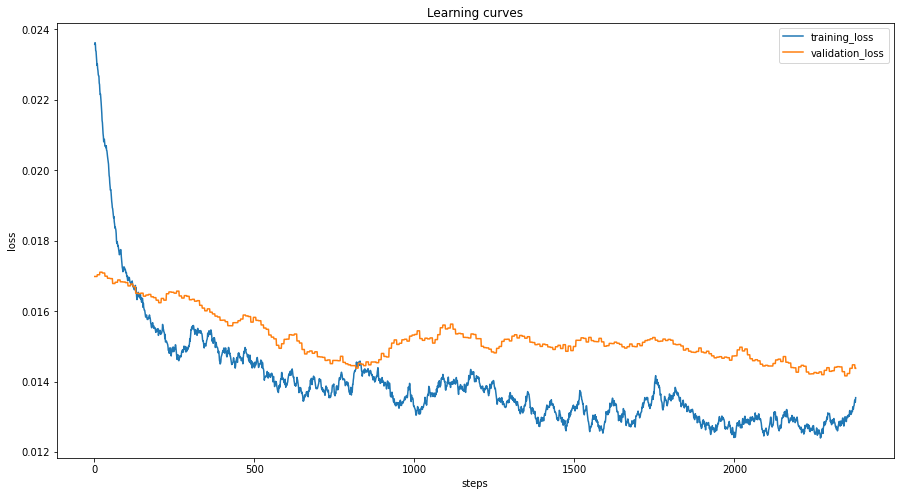

In [54]:
results_for_graph = results[['step', 'training_loss', 'validation_loss']].copy()
results_for_graph['training_loss'] = results_for_graph['training_loss'].ewm(span=100, adjust=False).mean()
results_for_graph['validation_loss'] = results_for_graph['validation_loss'].ewm(span=100, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,8))
plt.title('Learning curves')
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(results_for_graph['step'], results_for_graph['training_loss'], label='training_loss')
plt.plot(results_for_graph['step'], results_for_graph['validation_loss'], label='validation_loss')
leg = plt.legend(loc='upper right')
plt.show()

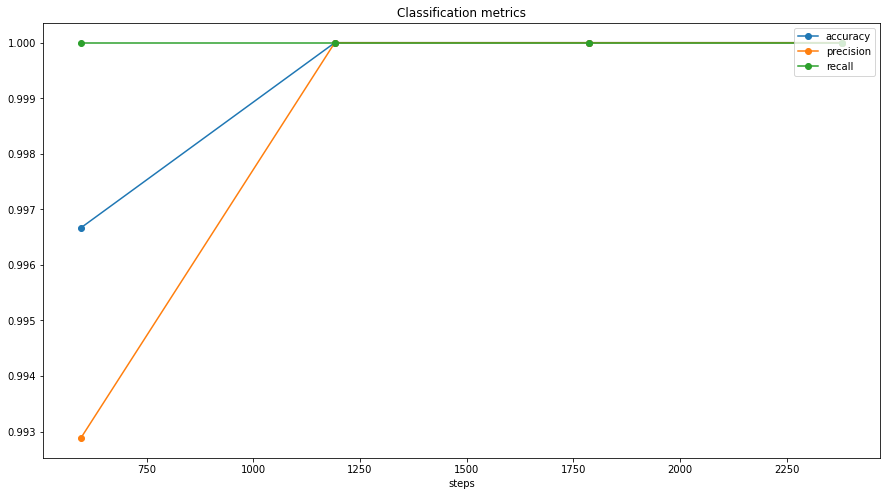

In [55]:
results_for_graph = results.copy()

fig, ax = plt.subplots(figsize=(15,8))
plt.title('Classification metrics')
plt.xlabel('steps')
plt.plot(
    results_for_graph['step'][np.isfinite(results_for_graph['classification/accuracy'])],
    results_for_graph['classification/accuracy'][np.isfinite(results_for_graph['classification/accuracy'])],
    label='accuracy',
    linestyle='-',
    marker='o'
)
plt.plot(
    results_for_graph['step'][np.isfinite(results_for_graph['classification/precision'])],
    results_for_graph['classification/precision'][np.isfinite(results_for_graph['classification/precision'])],
    label='precision',
    linestyle='-',
    marker='o'
)
plt.plot(
    results_for_graph['step'][np.isfinite(results_for_graph['classification/recall'])],
    results_for_graph['classification/recall'][np.isfinite(results_for_graph['classification/recall'])],
    label='recall',
    linestyle='-',
    marker='o'
)
leg = plt.legend(loc='upper right')
plt.show()

## Val exploration

In [56]:
df_val = pd.read_json('val_prepared.jsonl', lines=True, dtype={'prompt': str, 'completion': str})
print(df_val.shape)
df_val.head()

(600, 2)


,prompt,completion
0,Abstract:\nThe problem of joint power and sub-...,0
1,Abstract:\nPSR J1906+0746 is a pulsar located ...,1
2,Abstract:\nAfter a brief general introduction ...,0
3,Abstract:\n Recent advances in trainable infor...,1
4,Abstract:\nWe present a method for coarse-grai...,0


In [57]:
random_i = np.random.randint(0, df_val.shape[0])
res = openai.Completion.create(model=model_id, prompt=df_val['prompt'][random_i], max_tokens=1, temperature=0, logprobs=4)
print("Probabilities:", res['choices'][0]['logprobs']['top_logprobs'][0])
print("Completion:", '"' + res['choices'][0]['text'] + '"')
print("Correct value:", df_val['completion'][random_i])

Probabilities: {
  " 0": -12.874758,
  " 1": -2.6419024e-05,
  " 2": -11.816538,
  " The": -12.947756
}
Completion: " 1"
Correct value:  1


## Tesing

In [58]:
FINE_TUNE_ID = "ft-jWOie0pLdVX7GFUHY38F9bul"
TEST_DATA_FILES = [
    "classifier_input_restricted_test.csv",
    "data_nlp2022/gpt3curienlp2022_restricted_test.csv",
    "data_nlp2022/realnlp2022_restricted_4000.csv",
]
TEST_BATCH_SIZE = 1000

In [59]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
response = openai.FineTune.retrieve(id=FINE_TUNE_ID)
model_id = response["fine_tuned_model"]
model_id

'ada:ft-personal-2023-03-10-18-59-18'

In [60]:
def test_dataset(df):
  df_test_prepared = prepare_data(df)
  print("Value counts in test:")
  print(df_test_prepared["completion"].value_counts())
  # Create batches
  test_batches = [df]
  if df.shape[0] > TEST_BATCH_SIZE:
    test_batches = [df_test_prepared.loc[i:i+TEST_BATCH_SIZE-1,:] for i in range(0, len(df_test_prepared),TEST_BATCH_SIZE)]
  print("Number of test batches:", len(test_batches))
  # Remove long samples
  for i in range(len(test_batches)):
    test_batches[i]['tokens'] = test_batches[i].apply(lambda row: len(tokenizer(row['prompt'])['input_ids']), axis=1)
    mask = test_batches[i]['tokens'] > 2048
    if mask.any():
      print(f"Removing {mask.value_counts()[True]} samples in batch {i}")
      test_batches[i] = test_batches[i].drop(test_batches[i][mask].index)

  # Ask for completion
  results = []
  for i in range(len(test_batches)):
    print(f"Testing batch {i}")
    response = openai.Completion.create(model=model_id, prompt=test_batches[i]['prompt'].tolist(), max_tokens=1, temperature=0, logprobs=None)
    results.append(pd.DataFrame(response["choices"]))
    assert len(results[i]) == len(test_batches[i])
  
  # Merge results
  for i in range(len(test_batches)):
    results[i] = results[i].set_index('index')
    results[i] = results[i].drop(labels=['logprobs', 'finish_reason'], axis=1)
    results[i] = results[i].rename({'text': 'predicted'}, axis=1)
    results[i]['correct'] = test_batches[i]["completion"].values
    results[i]['prompt'] = test_batches[i]["prompt"].values
  results_all = pd.concat(results, ignore_index=True)

  return results_all

def analize_results(results):
  correctly_classified = results.loc[results['predicted'] == results['correct']]
  missclassified = results.loc[results['predicted'] != results['correct']]
  true_positive = correctly_classified.loc[correctly_classified['predicted'] == " 1"].shape[0]
  false_positive = missclassified.loc[missclassified['predicted'] == " 1"].shape[0]
  true_negative = correctly_classified.loc[correctly_classified['predicted'] == " 0"].shape[0]
  false_negative = missclassified.loc[missclassified['predicted'] == " 0"].shape[0]

  print("correctly_classified", correctly_classified.shape[0])
  print("missclassified", missclassified.shape[0])
  print("true_positive", true_positive)
  print("false_positive", false_positive)
  print("true_negative", true_negative)
  print("false_negative", false_negative)
  print()

  accuracy = 1 - missclassified.shape[0] / results.shape[0]
  if true_positive + false_positive > 0:
    precision = true_positive / (true_positive + false_positive)
  if true_positive + false_negative > 0:
    recall = true_positive / (true_positive + false_negative)
  if true_positive + false_positive > 0 and true_positive + false_negative > 0:
    f1 = 2*precision*recall / (precision + recall)

  print(f"Accuracy: {accuracy * 100}%")
  if true_positive + false_positive > 0:
    print(f"Precision: {precision * 100}%")
  if true_positive + false_negative > 0:
    print(f"Recall: {recall * 100}%")
  if true_positive + false_positive > 0 and true_positive + false_negative > 0:
    print(f"F1: {f1 * 100}%")

In [ ]:
results = {}

In [ ]:
for f in TEST_DATA_FILES:
  print("\n" + f)
  df = pd.read_csv(DRIVE_MOUNT_PATH + DATA_FOLDER + f)
  if f not in results:
    results[f] = test_dataset(df)
  analize_results(results[f])


classifier_input_restricted_test.csv
correctly_classified 7932
missclassified 3
true_positive 3998
false_positive 2
true_negative 3934
false_negative 1

Accuracy: 99.96219281663517%
Precision: 99.95%
Recall: 99.97499374843711%
F1: 99.96249531191398%

data_nlp2022/gpt3curienlp2022_restricted_test.csv
correctly_classified 259
missclassified 741
true_positive 259
false_positive 0
true_negative 0
false_negative 741

Accuracy: 25.900000000000002%
Precision: 100.0%
Recall: 25.900000000000002%
F1: 41.14376489277205%

data_nlp2022/realnlp2022_restricted_4000.csv
correctly_classified 3956
missclassified 37
true_positive 0
false_positive 37
true_negative 3956
false_negative 0

Accuracy: 99.07337841222139%
Precision: 0.0%


In [61]:
df = pd.read_csv(DRIVE_MOUNT_PATH + DATA_FOLDER + "classifier_input_restricted_test.csv")
df = df.loc[df['src'] == 'chatgpt']
df

,id,year,title,abstract,introduction,conclusion,categories,src,label
37,1404.7652,2014.0,Properties of Hartree-Fock solutions of the th...,The Hartree-Fock (HF) method is a widely used ...,The HF method is a self-consistent method for ...,"In this work, we have studied the properties o...",cond-mat.str-el,chatgpt,1
39,1002.1811,2010.0,Non-Gaussianities in the local curvature of th...,This study investigates the presence of non-Ga...,The CMB is a highly isotropic and homogeneous ...,Our analysis of the 5-year WMAP data reveals e...,astro-ph.CO,chatgpt,1
51,1507.08506,2015.0,Spatially-Resolved Dense Molecular Gas and Sta...,"M51, also known as the Whirlpool Galaxy, is a ...",Star formation is a fundamental process that o...,"In conclusion, our study of M51 has shown that...",astro-ph.GA,chatgpt,1
53,1311.5615,2013.0,Modified Friedmann Equation from Nonminimally ...,"In this paper, we derive the modified Friedman...",The Friedmann equation is a key equation in co...,"In summary, we have derived the modified Fried...",gr-qc,chatgpt,1
60,1806.07075,2018.0,On radical and torsion theory in the category ...,"In this paper, we study the radical and torsio...","Semigroup actions, or S-acts for short, have b...","In this paper, we have studied the radical and...",math.RT math.RA,chatgpt,1
...,...,...,...,...,...,...,...,...,...
7958,1704.03572,2017.0,Star formation rates and efficiencies in the G...,The Galactic Centre is a region of intense sta...,The Galactic Centre is the central region of t...,Our results show that the star formation rate ...,astro-ph.GA,chatgpt,1
7962,0801.3943,2008.0,Systems of energy emitting bodies and their pr...,This paper discusses the properties of systems...,Energy emitting bodies are a type of astronomi...,"In conclusion, systems of energy emitting bodi...",math.DS math-ph math.MP,chatgpt,1
7968,1711.00806,2017.0,Two-dimensional locally $\mathbb{K}$-Nash groups,"In this paper, we introduce the concept of two...",A Nash group is a topological group that is lo...,"In this paper, we have introduced the concept ...",math.AG,chatgpt,1
7969,1303.6037,2013.0,Potentials allowing integration of the perturb...,"The two-body problem in celestial mechanics, i...",The two-body problem has been a central proble...,"In this paper, we have shown that the perturbe...",nlin.SI math-ph math.MP,chatgpt,1


In [62]:
results_chatgpt = test_dataset(df)
analize_results(results_chatgpt)

Value counts in test:
 1    1000
Name: completion, dtype: int64
Number of test batches: 1
Testing batch 0
correctly_classified 1000
missclassified 0
true_positive 1000
false_positive 0
true_negative 0
false_negative 0

Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1: 100.0%
